# Convolutional Neural Network applied to Transient Detection

Updates to use leaky ReLUs from Deep-HiTS paper...

In [1]:
import numpy as np
import gzip
import matplotlib.pyplot as plt
%matplotlib inline

Put data loader into a function, break up potentially into train/valid/test subsets...

In [2]:
def load_pkl_data(chunk_num, split_frac=(0.8, 0.9), verbose=False):
    fname = 'all_chunks/chunk_%d_5000.pkl.gz' % chunk_num
    pkl_data = np.load(gzip.GzipFile(fname, 'rb'), encoding='bytes')
    if False:
        print(pkl_data.keys())
        print(pkl_data[b'diff_images'].shape)
    
    N_data = pkl_data[b'diff_images'].shape[0]
    if False:
        print(N_data)
    X = np.array([pkl_data[b'temp_images'].reshape((N_data, 21, 21)), 
                 pkl_data[b'sci_images'].reshape((N_data, 21, 21)),
                 pkl_data[b'diff_images'].reshape((N_data, 21, 21)),
                 pkl_data[b'SNR_images'].reshape((N_data, 21, 21))])
    X = np.swapaxes(X, 0, 1)

    Y = np.array([np.logical_not(pkl_data[b'labels']), pkl_data[b'labels']]).transpose()
    if False:
        print(X.shape, Y.shape)
        
    N_train = int(N_data * split_frac[0])
    N_valid = 0
    if split_frac[0] < 1.0:
        N_valid = int(N_data * split_frac[1])
    N_test = 0
    if split_frac[1] < 1.0:
        N_test  = int(N_data * 1.0)

    X_train, Y_train = X[:N_train], Y[:N_train]
    X_valid = Y_valid = None
    if N_valid > 0:
        X_valid, Y_valid = X[N_train:N_valid], Y[N_train:N_valid]
    X_test = Y_test = None
    if N_test > 0:
        X_test, Y_test = X[N_valid:N_test], Y[N_valid:N_test]

    if verbose:
        print(np.mean(Y[:,0]), np.mean(Y[:,1]))
        print("Train: ", X_train.shape, Y_train.shape)
        if N_valid > 0:
            print("Valid: ", X_valid.shape, Y_valid.shape)
        if N_test > 0:
            print("Test: ", X_test.shape, Y_test.shape)
        
    return (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test)

In [3]:
(X_train, Y_train), (X_test, Y_test), _ = load_pkl_data(188, (0.9, 1.0), verbose=True)

0.5 0.5
Train:  (4527, 4, 21, 21) (4527, 2)
Valid:  (503, 4, 21, 21) (503, 2)


We create a Keras sequential model and compile it.

In [4]:
from IPython.display import SVG
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils.vis_utils import plot_model, model_to_dot

# set dimensions ordering (depth as index 1)
import keras
keras.backend.set_image_dim_ordering('th')

from keras.layers.advanced_activations import LeakyReLU

# 0.04 and 0.5 and 1./100000 are params from Deep-HiTS paper
# decay = "reduced by half every 100,000 iterations"
def make_model(compile=True, epochs=100, lrate=0.04, dropout=0.5, decay=1./100000.,
              momentum=0.0, use_leaky=True):
    model = Sequential()
    model.add(ZeroPadding2D((3, 3), input_shape = (4, 21, 21)))
    if not use_leaky:
        model.add(Convolution2D(32, (4, 4), activation='relu'))
    else:
        model.add(Convolution2D(32, (4, 4)))
        model.add(LeakyReLU(alpha=0.01))
    model.add(ZeroPadding2D((1, 1)))
    if not use_leaky:
        model.add(Convolution2D(32, (3, 3), activation='relu'))
    else:
        model.add(Convolution2D(32, (3, 3)))
        model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    if not use_leaky:
        model.add(Convolution2D(64, (3, 3), activation='relu'))
    else:
        model.add(Convolution2D(64, (3, 3)))
        model.add(LeakyReLU(alpha=0.01))
    model.add(ZeroPadding2D((1, 1)))
    if not use_leaky:
        model.add(Convolution2D(64, (3, 3), activation='relu'))
    else:
        model.add(Convolution2D(64, (3, 3)))
        model.add(LeakyReLU(alpha=0.01))
    model.add(ZeroPadding2D((1, 1)))
    if not use_leaky:
        model.add(Convolution2D(64, (3, 3), activation='relu'))
    else:
        model.add(Convolution2D(64, (3, 3)))
        model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    if not use_leaky:
        model.add(Dense(64, activation='relu'))
    else:
        model.add(Dense(64))
        model.add(LeakyReLU(alpha=0.01))
    if dropout is not None:
        model.add(Dropout(dropout))
    if not use_leaky:
        model.add(Dense(64, activation='relu'))
    else:
        model.add(Dense(64))
        model.add(LeakyReLU(alpha=0.01))
    if dropout is not None:
        model.add(Dropout(dropout))
    model.add(Dense(2, activation='softmax'))
    
    if compile:
        # model.compile(loss='mean_squared_error',
        #       optimizer='sgd', metrics=['accuracy'])

        # initiate RMSprop optimizer (OLD)
        #opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

        # Compile model
        #epochs = 25
        #lrate = 0.01
        if decay is None:
            if epochs > 2:
                decay = lrate/epochs
            else:
                decay = lrate/100.
        opt = keras.optimizers.SGD(lr=lrate, momentum=momentum, decay=decay, nesterov=False)

        # Let's train the model using RMSprop
        model.compile(loss='mean_squared_error', #categorical_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy'])

    return model

Using TensorFlow backend.


In [5]:
epochs = 25
model = make_model(epochs=25)

In [6]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 4, 27, 27)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 24, 24)        2080      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 24, 24)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 32, 26, 26)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 24, 24)        9248      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 24, 24)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 12, 12)        0         
__________

Now, we fit our model to the training data-set

In [7]:
def run_model(model, train, valid, epochs=25, batch_size=32, data_augmentation=True, 
              patience=5, **kwargs):
    X_train, Y_train = train
    X_valid, Y_valid = valid
    
    from keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience)

    if not data_augmentation:
        if epochs > 2:
            print('Not using data augmentation.')
        histry = model.fit(X_train, Y_train, batch_size=batch_size, 
                  epochs=epochs, validation_data=(X_valid, Y_valid),
                  shuffle=True, callbacks=[early_stopping], **kwargs)
    else:
        if epochs > 2:
            print('Using real-time data augmentation.')
        from keras.preprocessing.image import ImageDataGenerator
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True)  # randomly flip images

        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        # datagen.fit(X_train)  # so not needed.

        # Fit the model on the batches generated by datagen.flow().
        histry = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size), 
                            epochs=epochs, validation_data=(X_valid, Y_valid),
                            steps_per_epoch=X_train.shape[0] // batch_size,
                            callbacks=[early_stopping], **kwargs) 
        
    return model, histry

In [8]:
def plot_misclassified(model, ypred, Y_test, nmax=10, only_plot_misclassified=True):
    ytest = Y_test[:, 1].astype(int)

    N_plot = nmax
    only_plot_wrong = only_plot_misclassified
    if not only_plot_wrong:
        plot_inds = range(N_plot)
    else:
        plot_inds = np.where(ypred != ytest)[0]
        print("Incorrectly classified: %d of %d" % (len(plot_inds), len(ypred)))
        if len(plot_inds) > N_plot:
            plot_inds = plot_inds[:N_plot]
    N_plot = len(plot_inds)

    plt.clf()
    fig, axes = plt.subplots(N_plot, 4, figsize=(4, N_plot*1.2),
                            subplot_kw={'xticks': [], 'yticks': []})
    i = 0
    for ind in plot_inds:
        axes.flat[4*i].imshow(X_test[ind][0], interpolation = "none")
        axes.flat[4*i + 1].imshow(X_test[ind][1], interpolation = "none")
        axes.flat[4*i + 2].imshow(X_test[ind][2], interpolation = "none")
        axes.flat[4*i + 3].imshow(X_test[ind][3], interpolation = "none")

        axes.flat[4*i + 3].set_title ("predicted pbb = " + str(np.round(ypred[ind], 2)) + 
                                      ", label = " + str(ytest[ind]))
        i += 1
    plt.show()

Now try fitting a large number of data in batches:

Try using `fit_generator()` with a data generator.

In [9]:
from keras.preprocessing.image import ImageDataGenerator

# This will do preprocessing and realtime data augmentation:
imageDatagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True)  # randomly flip images

In [11]:
batch_size = 32
seed = 666

def data_generator_train():
    data_range = np.arange(150)  # use inds 0-150 for training
    while True:
        chunk = np.random.choice(data_range, size=1)[0]
        print(' TRAIN:', chunk)
        (X, Y), _, _ = load_pkl_data(chunk, split_frac=(1.0, 1.0), verbose=False)
        for i in range(X.shape[0]//batch_size):  # about 5000/32 = 150
            Xb, Yb = imageDatagen.flow(X, Y, batch_size=batch_size).next()
            yield (Xb, Yb)

def data_generator_valid():
    data_range = np.arange(151, 235)  # use inds 151-234 for validation
    while True:
        chunk = np.random.choice(data_range, size=1)[0]
        print(' VALID:', chunk)
        (X, Y), _, _ = load_pkl_data(chunk, split_frac=(1.0, 1.0), verbose=False)
        for i in range(X.shape[0]//batch_size): # about 5000/32 = 150
            Xb, Yb = imageDatagen.flow(X, Y, batch_size=batch_size).next()
            yield (Xb, Yb)
        
# Then we can use inds 235-284 as test data.
def data_generator_test():
    data_range = np.arange(235, 285)  # use inds 235-284 for test
    while True:
        chunk = np.random.choice(data_range, size=1)[0]
        print(' TEST:', chunk)
        (X, Y), _, _ = load_pkl_data(chunk, split_frac=(1.0, 1.0), verbose=False)
        for i in range(X.shape[0]//batch_size): # about 5000/32 = 150
            Xb, Yb = imageDatagen.flow(X, Y, batch_size=batch_size).next()
            yield (Xb, Yb)

Trick to get this to work is make `steps_per_epoch` greater than (or approx. equal to)  `X.shape[0]//batch_size` so that it reads in multiple data sets per epoch. The point is, don't make `steps_per_epoch` too small, or it will only work on a few data sets over many epochs. Then make `validation_steps` also be big to use many batches of validation data (probably want it to also be greater than `X.shape[0]//batch_size`).

In [12]:
# Here's an example of how to track the learning rate.
# Taken from here: https://github.com/fchollet/keras/issues/2823

import keras.backend as kbackend

class SGDLearningRateTracker(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        lr = kbackend.eval(optimizer.lr * (1. / (1. + optimizer.decay * optimizer.iterations)))
        print('\nLR: {:.6f}\n'.format(lr))

In [13]:
np.random.seed(seed)

epochs = 10000
model = make_model(compile=True, epochs=epochs, lrate=0.04, decay=1./100000.)

train_generator = data_generator_train()
valid_generator = data_generator_valid()

from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=1000)
checkpointing = ModelCheckpoint('model.{epoch:05d}-{val_loss:.6f}.hdf5', #''./best_model.hdf5', 
                                monitor='val_loss', verbose=1, 
                                save_best_only=True, save_weights_only=False, 
                                mode='auto', period=1)

rateChecking = SGDLearningRateTracker()

# steps_per_epoch=5000: 5000/32=156 chunks trained per epoch,
# then validation_steps=500: 500/32=15.6 chunks tested per epoch
model.fit_generator(generator=train_generator, 
                    validation_data = valid_generator, validation_steps=500,
                    #datagen.flow(X_train, Y_train, batch_size=batch_size), 
                    epochs=epochs, steps_per_epoch=5000,
                    callbacks=[early_stopping, checkpointing, rateChecking], workers=1)

 TRAIN:Epoch 1/10000 
17
4999/5000 [============================>.] - ETA: 0s - loss: 0.0282 - acc: 0.9683 VALID: 159
 VALID: 207
 VALID: 194
 VALID: 181
Epoch 00000: val_loss improved from inf to 0.01753, saving model to ./best_model.hdf5

LR: 0.038095

5000/5000 [==============================] - 1405s - loss: 0.0282 - acc: 0.9683 - val_loss: 0.0175 - val_acc: 0.9811
Epoch 2/10000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0179 - acc: 0.9808 VALID: 220
 VALID: 220
 VALID: 188
Epoch 00001: val_loss improved from 0.01753 to 0.01386, saving model to ./best_model.hdf5

LR: 0.036364

5000/5000 [==============================] - 1350s - loss: 0.0179 - acc: 0.9807 - val_loss: 0.0139 - val_acc: 0.9834
Epoch 3/10000
2474/5000 [=============>................] - ETA: 686s - loss: 0.0150 - acc: 0.9835 TRAIN: 129


4999/5000 [============================>.] - ETA: 0s - loss: 0.0158 - acc: 0.9827 VALID: 205
 VALID: 219
 VALID: 166
Epoch 00002: val_loss improved from 0.01386 to 0.01280, saving model to ./best_model.hdf5

LR: 0.034783

5000/5000 [==============================] - 1365s - loss: 0.0158 - acc: 0.9827 - val_loss: 0.0128 - val_acc: 0.9861
Epoch 4/10000
 TRAIN: 98
 113/5000 [..............................] - ETA: 1158s - loss: 0.0102 - acc: 0.9878

KeyboardInterrupt: 

In [18]:
model = keras.models.load_model('./best_model.hdf5')  # Link your favorite model to this name

In [19]:
test_generator = data_generator_test()
score = model.evaluate_generator(test_generator, steps=500)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

 TEST: 256
 TEST: 247
 TEST: 243
 TEST: 283
Test loss: 0.00907035643164
Test accuracy: 0.9901875


In [26]:
from sklearn import metrics

(X_test, Y_test), _, _ = load_pkl_data(235, split_frac=(1.0, 1.0), verbose=False)

pred_classes = model.predict_classes(X_test)
print(metrics.classification_report(Y_test[:,1].astype(int), pred_classes))

5120/5120 [==============================] - 17s    
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      2560
          1       0.99      0.99      0.99      2560

avg / total       0.99      0.99      0.99      5120



5120/5120 [==============================] - 16s    


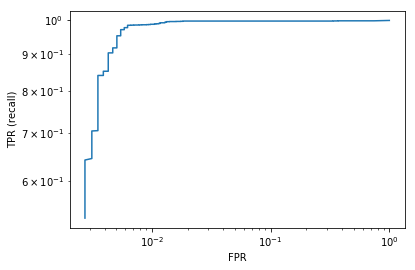

In [30]:
pred = model.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(Y_test[:,1], pred[:,1])
plt.loglog(fpr, tpr, label='ROC Curve')
plt.xlabel('FPR'); plt.ylabel('TPR (recall)')

Incorrectly classified: 52 of 5120


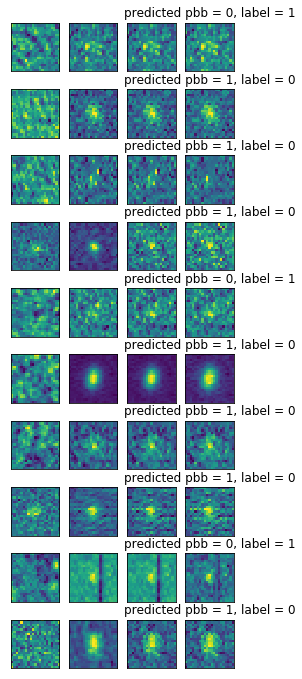

In [31]:
plot_misclassified(model, pred_classes, Y_test, nmax=10, only_plot_misclassified=True)

Try re-starting a loaded model...

In [32]:
model.fit_generator(generator=train_generator, 
                    validation_data = valid_generator, validation_steps=500,
                    epochs=epochs, steps_per_epoch=5000,
                    callbacks=[early_stopping, checkpointing, rateChecking], workers=1)

Epoch 1/10000
 137/5000 [..............................] - ETA: 1270s - loss: 0.0114 - acc: 0.9872

KeyboardInterrupt: 